In [ ]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import sys
sys.path.append('..')
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
config.update("jax_enable_x64", True)
import scienceplots
plt.style.use(['science','ieee'])


True


In [2]:
signal_params = ConfigDict(KDV_params_2)
print(signal_params)

Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 1
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 2.0e-05
c_4: 0.0
dt: 0.001
equation_name: KdV
initial_condition: gaussian
method: Dealiased_SETDRK4
noise_magnitude: 0.0
nt: 4000
nx: 256
tmax: 4
xmax: 1
xmin: 0



In [3]:
import numpy as np

signal_params.update(E=1,method='Dealiased_ETDRK4',nx = 128*16,P=0,S=0,tmax=4,initial_condition='gaussian')
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
# Create 100 Gaussian centers randomly distributed in the domain
# initial_signal = jnp.sin(4*jnp.pi*signal_model.x)**6
# initial_signal = jnp.tile(initial_signal, (signal_params.E, 1))
# initial_signal = initial_signal / initial_signal.max()


In [4]:
key = jax.random.PRNGKey(0)
final, all = signal_model.run(initial_signal, signal_model.params.nt, None,key) #the final input is scan length? 
# note that a 

In [5]:
print(type(all))
print(len(all))
print(all[0].shape) # particles
print(all[1].shape) # signal
time = jnp.linspace(0,signal_params.tmax,signal_model.params.nt+1)
print(time[1]-time[0],signal_model.params.dt)   

<class 'jaxlib.xla_extension.ArrayImpl'>
4000
(1, 2048)
(1, 2048)
0.001 0.001


In [6]:
print(initial_signal.shape)
print(all.shape)
signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
print(signal.shape)

(1, 2048)
(4000, 1, 2048)
(4001, 1, 2048)


In [7]:
def plot(da_step):
    plt.rcParams["figure.figsize"] = (20,3)
    plt.plot(signal_model.x, signal[da_step,0,:], color='k')
    plt.legend(['signal'])
    plt.show()

interact(plot, da_step=(0, signal_model.params.nt))

interactive(children=(IntSlider(value=2000, description='da_step', max=4000), Output()), _dom_classes=('widget…

<function __main__.plot(da_step)>

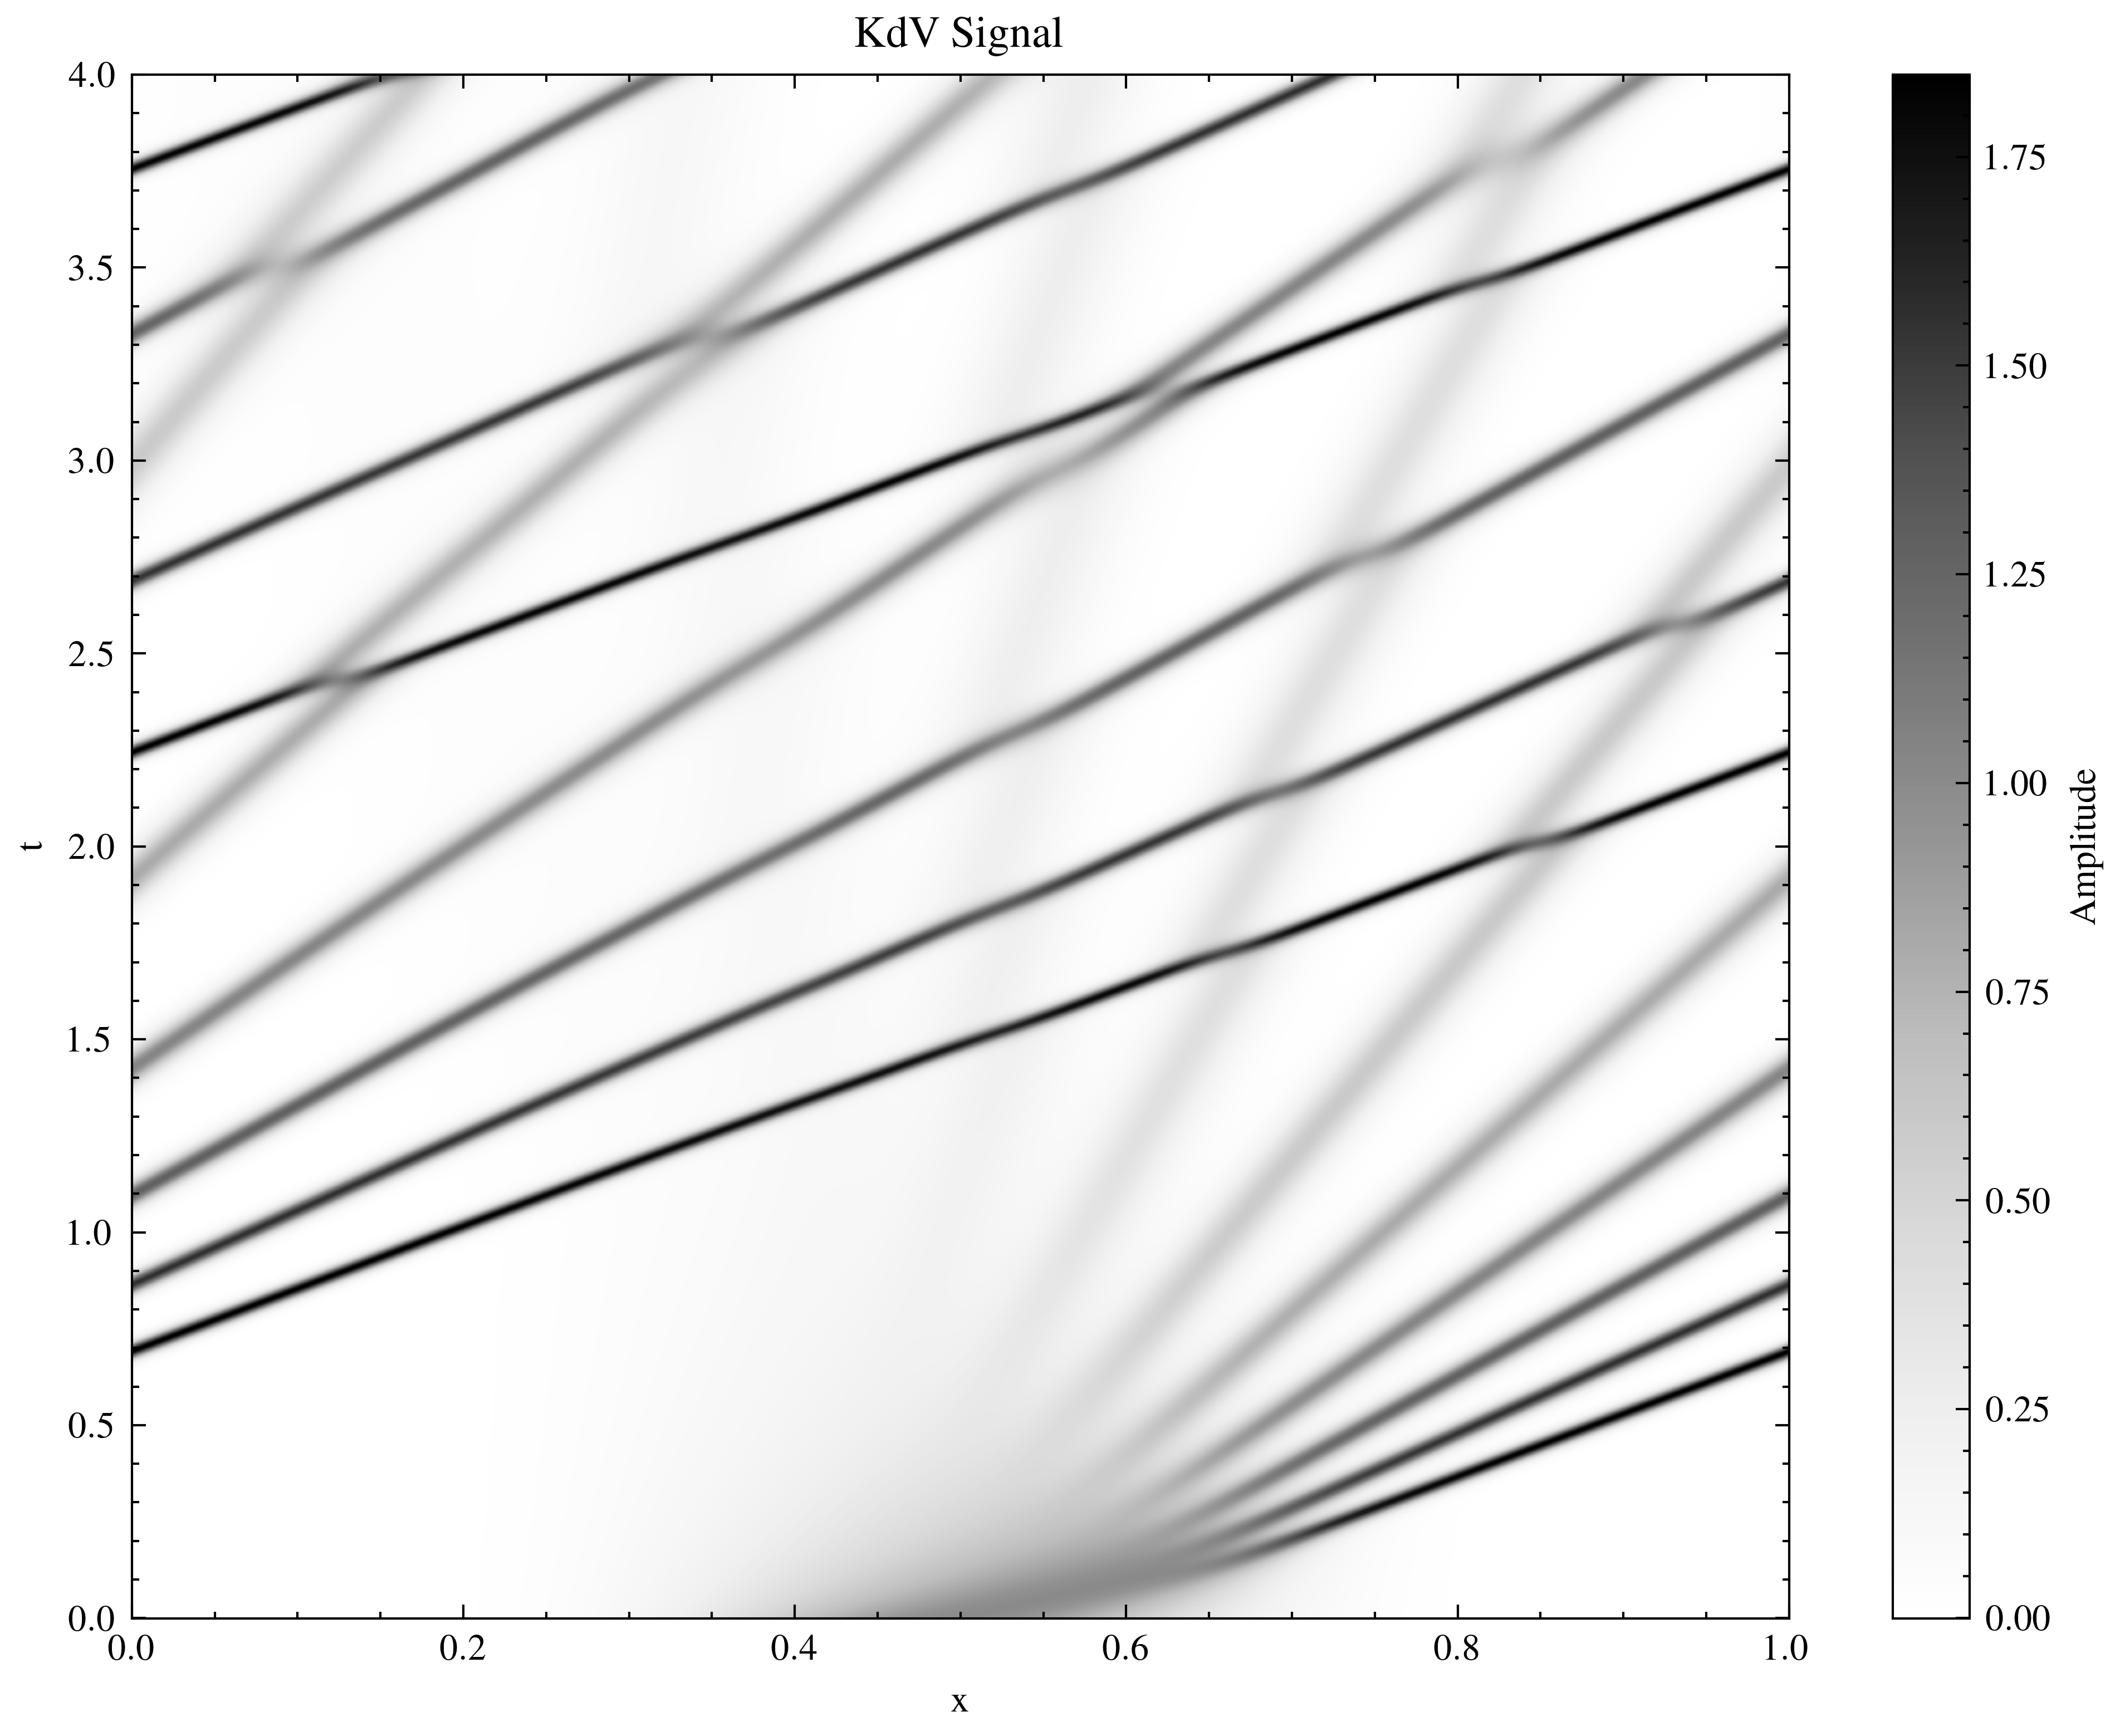

In [8]:
# plt.rcParams["figure.figsize"] = (4,4)
# plt.axis('equal')
# plt.title('Signal KdV')
# plt.imshow(all[:,0,:], aspect='auto',origin='lower',cmap='turbo')
# plt.colorbar()
# plt.xlabel('x')
# plt.ylabel('t')
# plt.show()

X, T = jnp.meshgrid(signal_model.x, time)
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, T, signal[:, 0, :], cmap='Greys')

plt.colorbar(label='Amplitude')
plt.xlabel('x')
plt.ylabel('t')
plt.title('KdV Signal')
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/KdV_High_res.png', dpi=300, bbox_inches='tight')
plt.show()

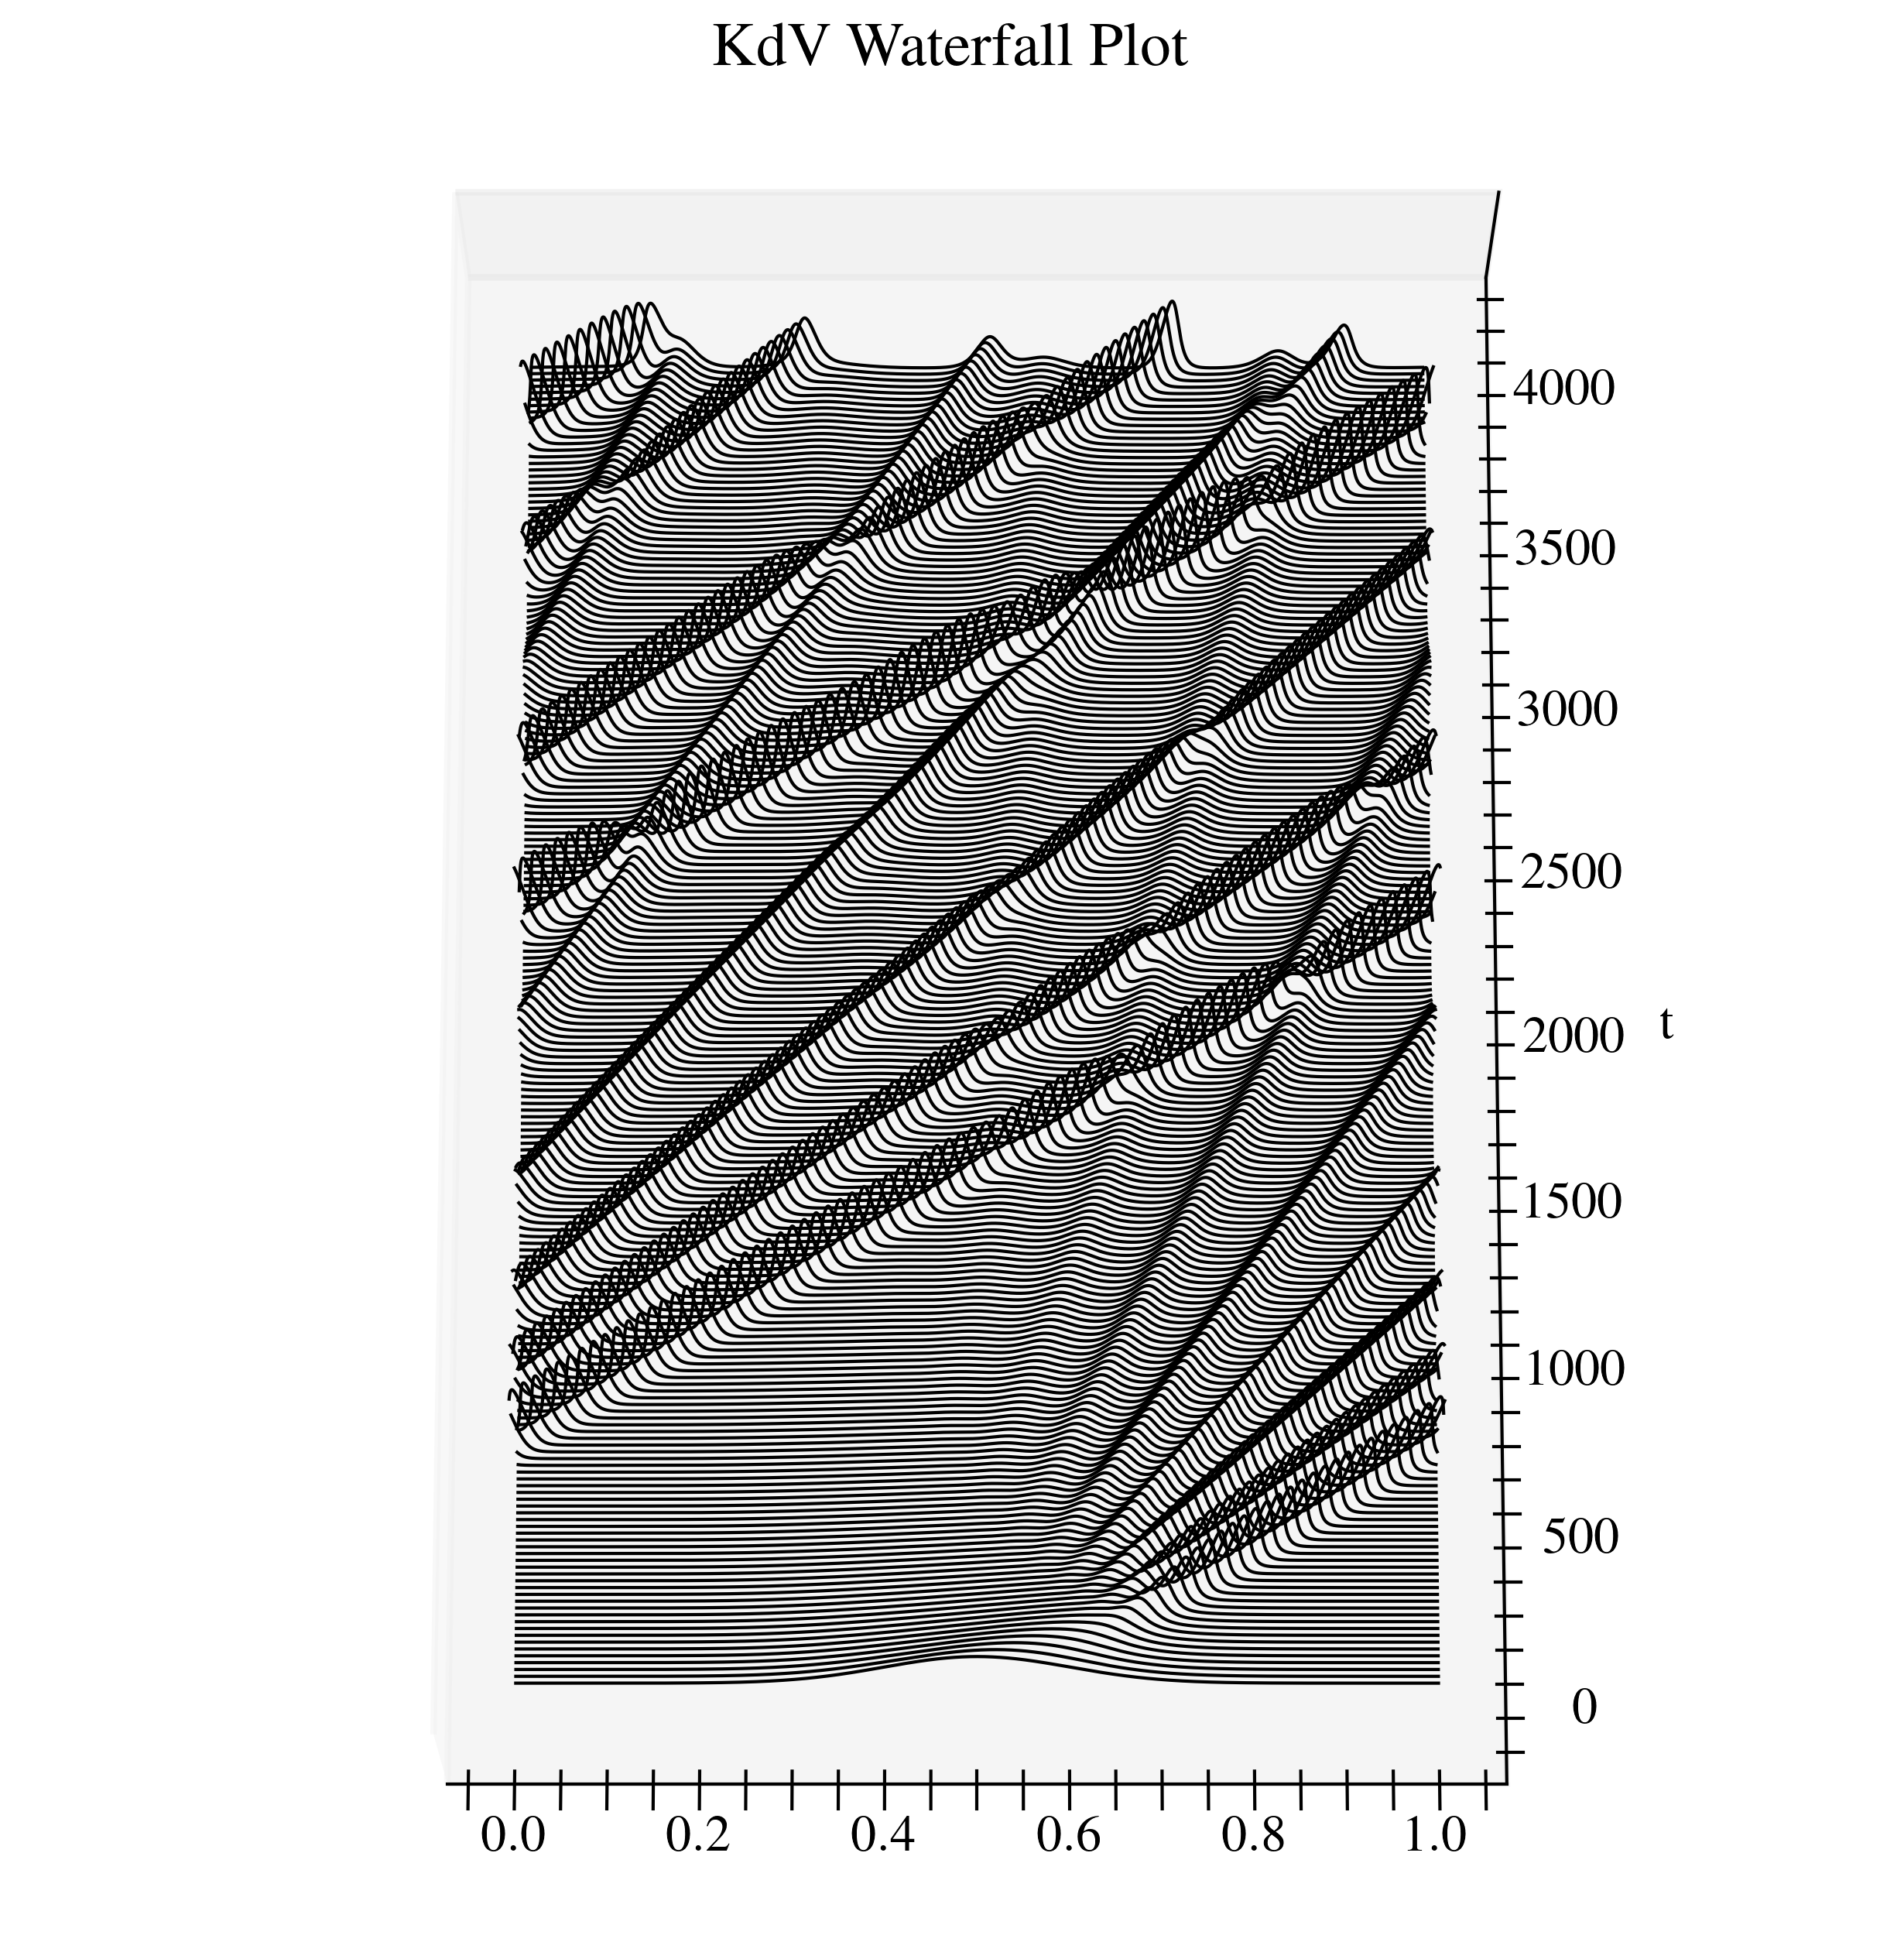

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_surface_waterfall(x_axis, data, y_axis=None, num_lines=None, line_indices=None):
    """
    Creates a 3D surface plot from a 2D NumPy array.
    
    Parameters:
        x_axis (ndarray): 1D array representing the x-axis.
        data (ndarray): 2D array of shape (N, M), where:
                        - N: number of curves
                        - M: number of points per curve
        y_axis (ndarray, optional): 1D array representing the y-axis. If None, uses indices.
        num_lines (int, optional): Number of curves to plot. If None, plots all.
        line_indices (list, optional): Specific indices of curves to plot. If provided, overrides num_lines.
    """
    N, E, M = data.shape  # Get dimensions
    x = x_axis
    y = y_axis if y_axis is not None else np.arange(N)

    # Determine which rows to plot
    if line_indices is not None:
        indices = np.array(line_indices)
    elif num_lines is None or num_lines >= N:
        indices = np.arange(N)
    else:
        indices = np.linspace(0, N - 1, num_lines, dtype=int)
    # Create a 3D figure
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, projection='3d')
    ax.tick_params(axis='x', pad=-5)
    for i, idx in enumerate(indices):
        ax.plot(x, np.full_like(x, y[idx]), data[idx, 0, :], label=f'Curve {idx}' if i % 5 == 0 else '', c='k', linestyle='solid',linewidth=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_box_aspect([2, 3, 0.5])
    ax.set_title('KdV Waterfall Plot', pad=-100)
    
    ax.view_init(elev=75, azim=270)
    ax.grid(False)
    ax.set_zticks([])
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    #plt.tight_layout()
    #fig.tight_layout()
    ##fig.set_size_inches(3, 3) 
    plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/KdV_Waterfall.png', dpi=300, bbox_inches="tight")
 
    return fig, ax
plot_surface_waterfall(signal_model.x, signal, line_indices=np.arange(0,4000,20))

plt.show()

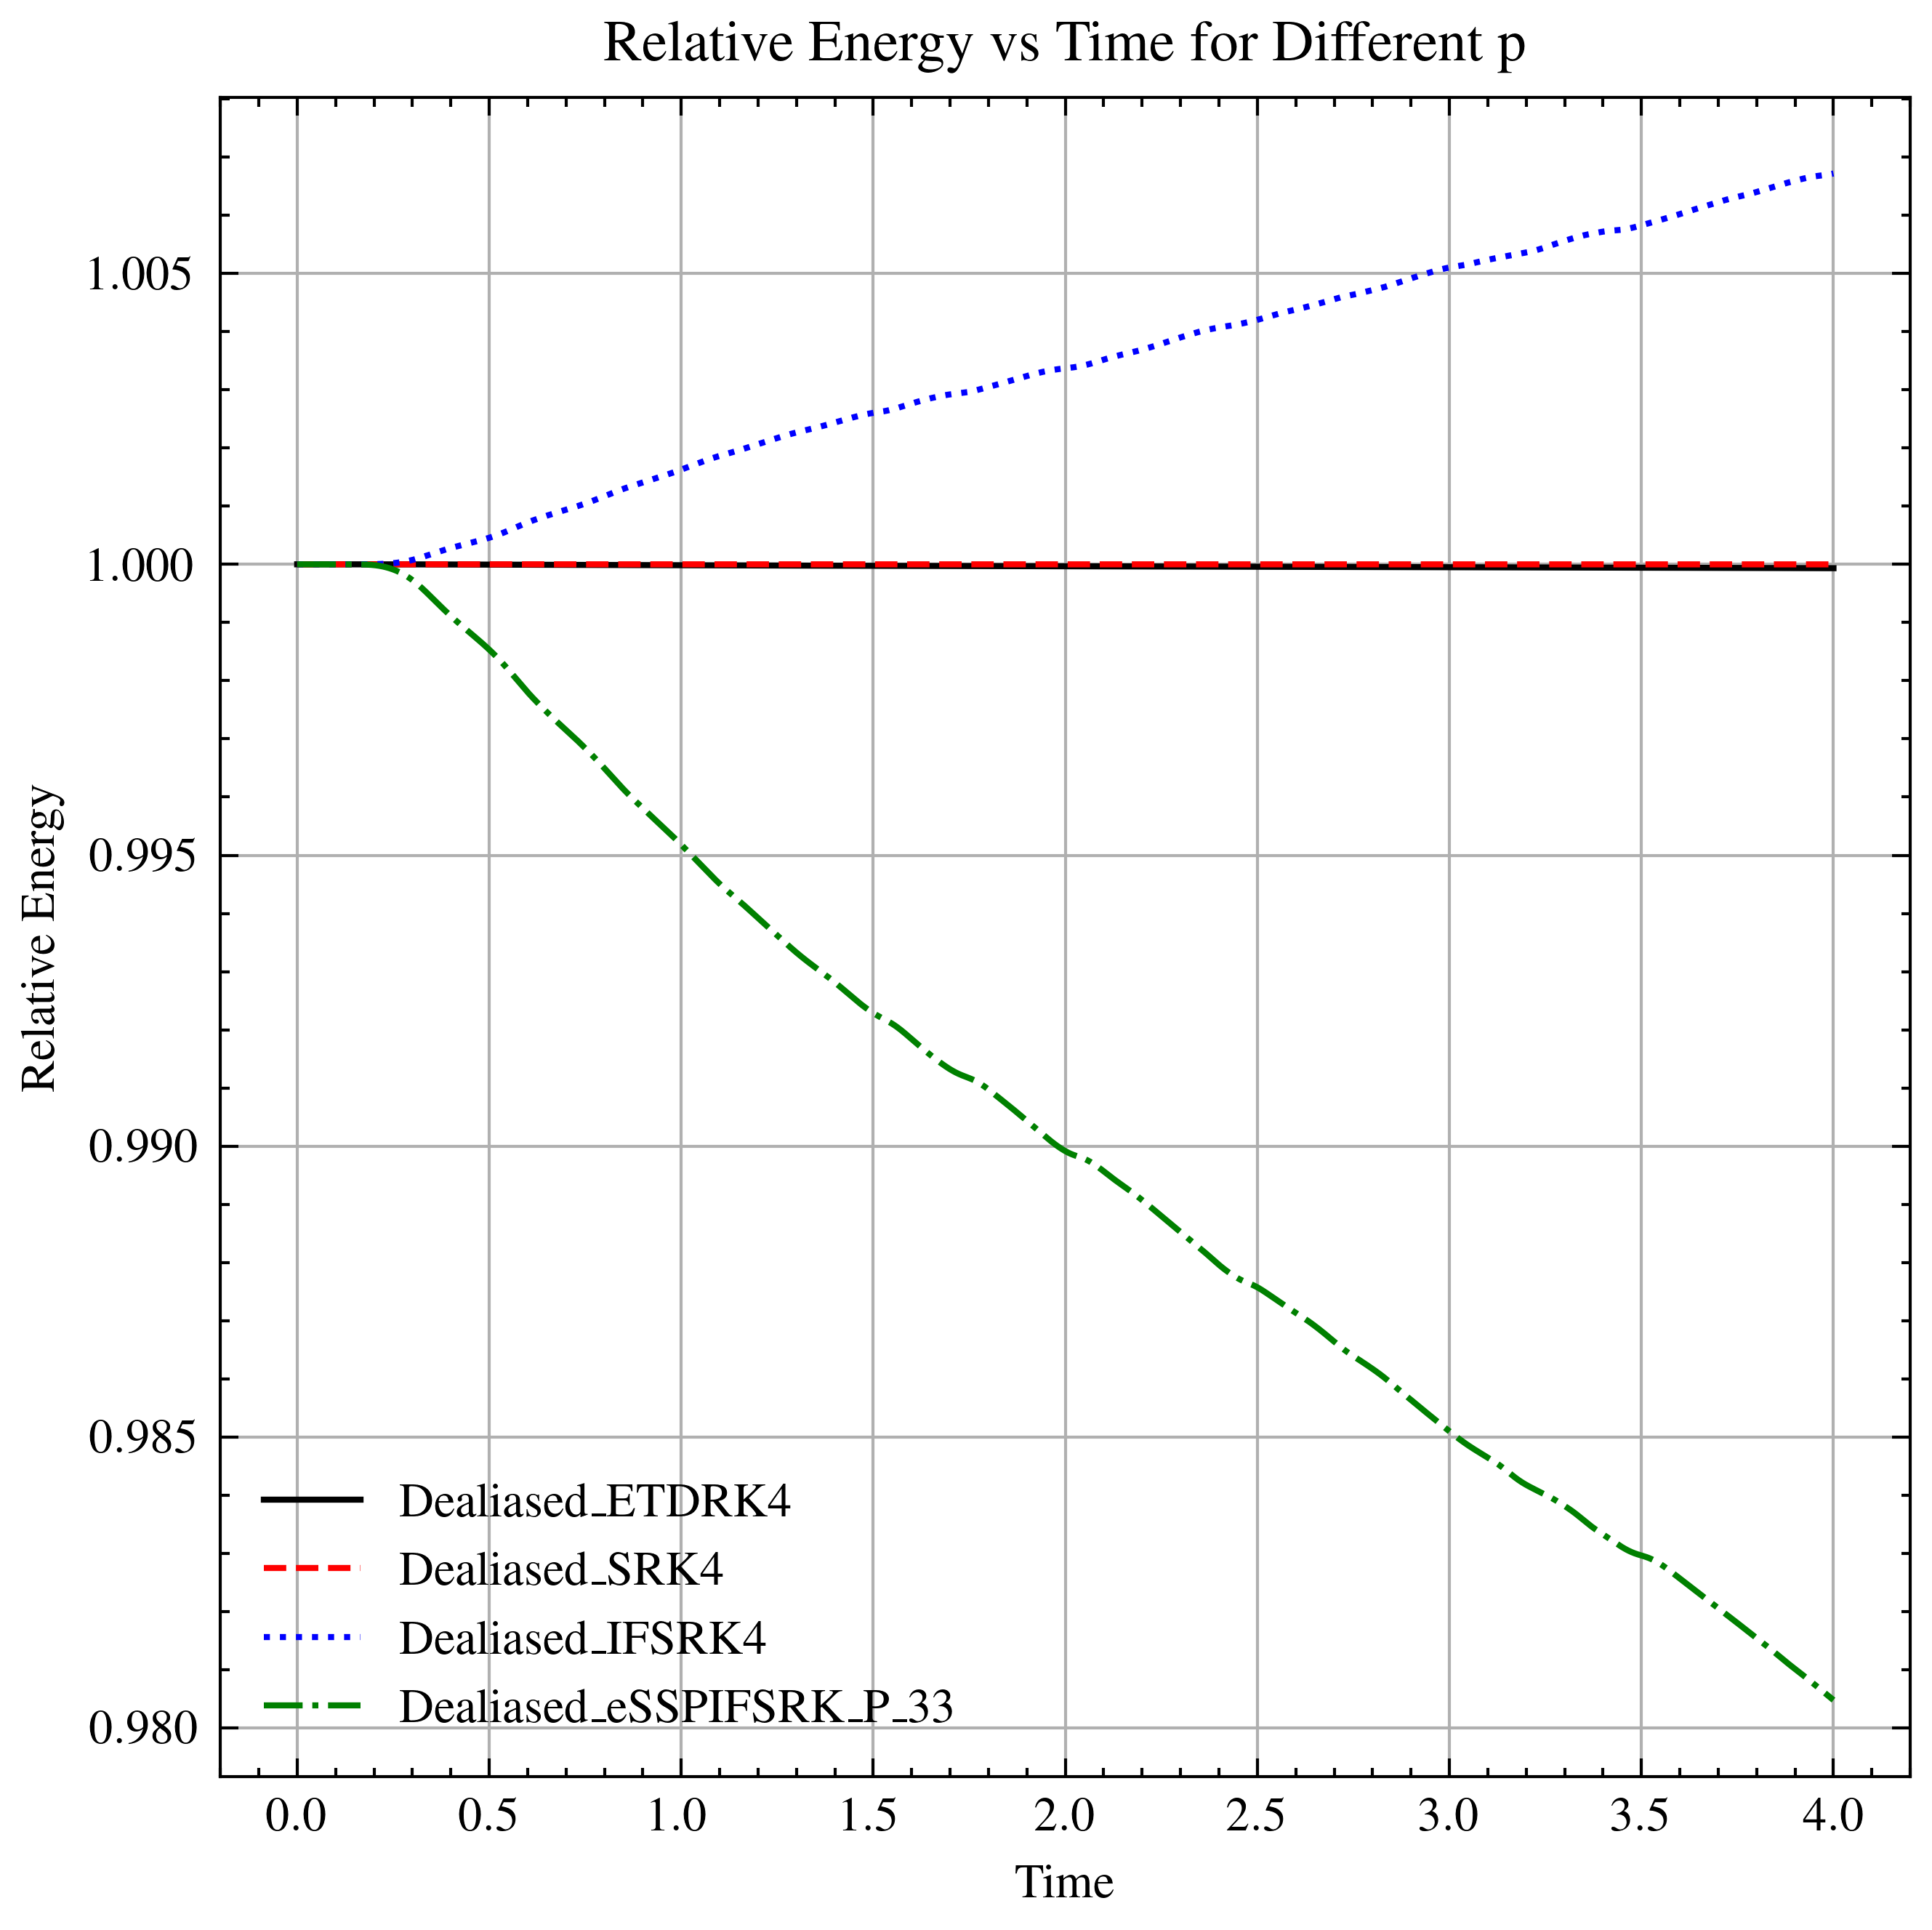

In [14]:
import numpy as np
plt.figure(figsize=(5, 5))
#plt.yscale('log')  # Use logarithmic scale for y-axis
method_names = ['Dealiased_ETDRK4', 'Dealiased_SRK4','Dealiased_IFSRK4', 'Dealiased_eSSPIFSRK_P_33']
for i in range(len(method_names)):
    signal_params.update(E=1,method=method_names[i],nx = 128,P=0,S=0,dt=0.001,nt=4000,tmax=4,initial_condition='gaussian')
    signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
    initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
    key = jax.random.PRNGKey(0)
    final, all = signal_model.run(initial_signal, signal_model.params.nt, None,key) 
    signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
    time = jnp.linspace(0,signal_params.tmax,signal_model.params.nt+1)
    energy = (jnp.sum(signal[:, 0, :]**2, axis=1))
    relative_energy = energy / energy[0]
    plt.plot(time, relative_energy, label=f'{method_names[i]}')
plt.xlabel('Time')
plt.ylabel('Relative Energy')
plt.title('Relative Energy vs Time for Different p')
plt.legend()
plt.grid(True)